<h1>Climate Change and its Impact on Health</h1>
<h3>Project Team Members:</h3>
<ul><li>Ameya Shanbhag (avs431)</li>
<li>Titash Mandal (tm2761)</li>
<li>Vikram Sunil Bajaj (vsb259)</li></ul>

<h3> Loading the data</h3>

In [1]:
import pyspark
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
df = sqlContext.read.csv("pollution_us_2000_2016.csv", header=True)
# df.printSchema()
df.registerTempTable("Pollution")

In [2]:
type(df)

pyspark.sql.dataframe.DataFrame

<h3> Changing the data type of certains columns to allow querying.</h3>

In [3]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
# converting the date from string to DateTime format using UDF
func =  udf (lambda x: datetime.strptime(x, '%Y-%m-%d'), DateType())
df_new = df.withColumn('Date', func(col('Date Local')))


In [4]:
from pyspark.sql.types import DoubleType
df_new = df_new.withColumn("N02AQI", df_new["NO2 AQI"].cast(DoubleType()))
df_new = df_new.withColumn("SO2 AQI", df_new["SO2 AQI"].cast(DoubleType()))
df_new = df_new.withColumn("CO AQI", df_new["CO AQI"].cast(DoubleType()))
df_new = df_new.withColumn("O3 AQI", df_new["O3 AQI"].cast(DoubleType()))
df_new.registerTempTable("Pollution_Data")

<h3> Each day has various NO2 AQI levels. <p>We select the daily Maximum NO2 AQI and SO2 AQI for every day of every  month with years ranging from 2000-2016</p></h3>

In [5]:
q2 = sqlContext.sql("SELECT MAX(`NO2 AQI`) as Max_NO2 , MAX(`SO2 AQI`) as SO2_AQI, City,Year(Date) as Yearly FROM Pollution_Data GROUP BY Day(Date),City,Year(Date) ORDER BY City,YEAR(Date)")
q2.registerTempTable('q2')

<h3> Select the maximum yearly AQI values for every city. </h3>

In [6]:
q2_sub = sqlContext.sql("SELECT MAX(Max_NO2) as x, MAX(SO2_AQI) as SO2_AQI, City, Yearly FROM q2 GROUP BY Yearly, City ORDER BY Yearly,City")
q2_sub.registerTempTable("q2_sub")

<h3> We filter out the AQI values lesser than 80 as an AQI of 80 is concerned as a dangerous level for pollutants in the air </h3>

In [7]:
sqlContext.sql("SELECT Yearly, count(City) FROM q2_sub WHERE x >80 OR SO2_AQI>80 GROUP BY Yearly ORDER BY Yearly").show(100)

+------+-----------+
|Yearly|count(City)|
+------+-----------+
|  2000|         52|
|  2001|         41|
|  2002|         42|
|  2003|         41|
|  2004|         35|
|  2005|         34|
|  2006|         39|
|  2007|         34|
|  2008|         29|
|  2009|         20|
|  2010|         12|
|  2011|         14|
|  2012|         13|
|  2013|          7|
|  2014|         13|
|  2015|         10|
|  2016|          3|
+------+-----------+



In [8]:
sqlContext.sql("SELECT City, Yearly FROM q2_sub WHERE Yearly=2016 AND x >80 OR SO2_AQI>80").show(20)

+--------------------+------+
|                City|Yearly|
+--------------------+------+
|          Alexandria|  2000|
|             Ashland|  2000|
|         Baton Rouge|  2000|
|        Beaver Falls|  2000|
|             Bristol|  2000|
|Calumet City (PU ...|  2000|
|              Camden|  2000|
|           Charleroi|  2000|
|           Charlotte|  2000|
|             Chicago|  2000|
|             Detroit|  2000|
|            Ferguson|  2000|
|          Greensburg|  2000|
|           Hawthorne|  2000|
|           Henderson|  2000|
|          Holtsville|  2000|
|             Houston|  2000|
|Indianapolis (Rem...|  2000|
|           Johnstown|  2000|
|         Kansas City|  2000|
+--------------------+------+
only showing top 20 rows



<h3> We wanted to check for any city which has atleast 3 pollutants having AQI >80. 
We found out that Houston and Kansas City have a high pollution level with 3 gases in the higher AQI level. 
No other combination of gases gave any output for a city.</h3>

In [9]:
sqlContext.sql(" SELECT State, City, MAX(`NO2 AQI`) as Max_NO2_AQI , MAX(`SO2 AQI`) AS MAX_SO2_AQI, MAX(`O3 AQI`) AS O3_AQI, MAX(`NO2 AQI`) AS NO2_AQI, YEAR(Date) as Yearly FROM Pollution_Data WHERE `O3 AQI` > 80 AND `SO2 AQI`>80 AND `NO2 AQI`>80 GROUP BY YEAR(Date),State,City ORDER BY  YEAR(Date)").show(100)

+------+-----------+-----------+-----------+------+-------+------+
| State|       City|Max_NO2_AQI|MAX_SO2_AQI|O3_AQI|NO2_AQI|Yearly|
+------+-----------+-----------+-----------+------+-------+------+
| Texas|    Houston|        101|       86.0| 150.0|    101|  2000|
|Kansas|Kansas City|        103|       97.0| 200.0|    103|  2005|
+------+-----------+-----------+-----------+------+-------+------+



In [10]:
sqlContext.sql(" SELECT State, City, MAX(`SO2 AQI`) as Max_SO2_AQI , MAX(`O3 AQI`) AS MAX_O3_AQI, MAX(`CO AQI`) AS CO_AQI, MAX(`NO2 AQI`) AS NO2_AQI, YEAR(Date) as Yearly FROM Pollution_Data WHERE `O3 AQI` > 80 AND `SO2 AQI`>80 AND `CO AQI`>80 GROUP BY YEAR(Date),State,City ORDER BY  YEAR(Date)").show(100)

+-----+----+-----------+----------+------+-------+------+
|State|City|Max_SO2_AQI|MAX_O3_AQI|CO_AQI|NO2_AQI|Yearly|
+-----+----+-----------+----------+------+-------+------+
+-----+----+-----------+----------+------+-------+------+



In [11]:
most_polluted_cities_yearly =sqlContext.sql("SELECT State, City, MAX(`N02AQI`) as Max_NO2_AQI , YEAR(Date) as Yearly FROM Pollution_Data WHERE `N02AQI`>80 GROUP BY YEAR(Date),City,State ORDER BY  YEAR(Date),MAX(`N02AQI`) DESC")
most_polluted_cities_yearly.registerTempTable("most_polluted_cities_yearly")

<h3> Yearly most polluted cities ordered in Desceding order by AQI Levels with years ranging from 2000-2016.</h3>

In [134]:
sqlContext.sql("SELECT State,City, MAX(`N02AQI`) as Max_NO2_AQI , MAX(`SO2 AQI`) as Max_SO2_AQI , MAX(`O3 AQI`) AS MAX_O3_AQI, MAX(`CO AQI`) AS CO_AQI, YEAR(Date) as Yearly FROM Pollution_Data GROUP BY YEAR(Date),City,State ORDER BY  YEAR(Date)").show(30)

+--------------------+--------------------+-----------+-----------+----------+------+------+
|               State|                City|Max_NO2_AQI|Max_SO2_AQI|MAX_O3_AQI|CO_AQI|Yearly|
+--------------------+--------------------+-----------+-----------+----------+------+------+
|            Missouri|           St. Louis|       80.0|      103.0|     140.0|  52.0|  2000|
|          California|       Not in a city|       84.0|       21.0|     154.0|  35.0|  2000|
|        Pennsylvania|             Reading|       57.0|      135.0|     172.0|  22.0|  2000|
|            Virginia|          Alexandria|       74.0|      109.0|     150.0|  25.0|  2000|
|          California|          Long Beach|      108.0|       65.0|     114.0|  63.0|  2000|
|            Michigan|             Detroit|       93.0|      134.0|     114.0|  51.0|  2000|
|          California|           Davenport|       33.0|       33.0|      47.0|   9.0|  2000|
|          California|              Goleta|       54.0|       13.0|   

In [138]:
t1=sqlContext.sql("SELECT State,City, MAX(`N02AQI`) as Max_NO2_AQI , MAX(`SO2 AQI`) as Max_SO2_AQI , MAX(`O3 AQI`) AS MAX_O3_AQI, MAX(`CO AQI`) AS Max_CO_AQI, YEAR(Date) as Yearly FROM Pollution_Data GROUP BY YEAR(Date),City,State ORDER BY  YEAR(Date)")
t1.registerTempTable("Entire_Pollution")

<h3> We wanted to check which cities have constantly featured as having a higher pollution level as compared to other cities. <p>We ranked every city based on their pollution level and found the top polluted cities.
These cities have constantly shown up in many consecutive years.<p> </h3>

In [13]:
Top_polluted_cities=sqlContext.sql("SELECT State,City,COUNT(Yearly) as Count  FROM most_polluted_cities_yearly GROUP BY City,State ORDER BY COUNT(Yearly) DESC LIMIT 10")
Top_polluted_cities.registerTempTable("Top_polluted_cities")
Top_polluted_cities.show(20)


+--------------------+------------+-----+
|               State|        City|Count|
+--------------------+------------+-----+
|          California|    Calexico|   16|
|          California| Los Angeles|   15|
|          California|  Long Beach|   14|
|            New York|    New York|   13|
|          California|   San Diego|   11|
|            Colorado|       Welby|   11|
|District Of Columbia|  Washington|   11|
|          California|     Burbank|   11|
|               Texas|     El Paso|   10|
|        Pennsylvania|Philadelphia|   10|
+--------------------+------------+-----+



In [14]:
table_state=sqlContext.sql("SELECT Top_polluted_cities.City as City, Top_polluted_cities.State as State, most_polluted_cities_yearly.Max_NO2_AQI, most_polluted_cities_yearly.Yearly  as Yearly FROM Top_polluted_cities JOIN most_polluted_cities_yearly ON Top_polluted_cities.City=most_polluted_cities_yearly.City GROUP BY Top_polluted_cities.`City`,most_polluted_cities_yearly.Max_NO2_AQI,most_polluted_cities_yearly.Yearly ,Top_polluted_cities.`State` ORDER BY Top_polluted_cities.`City`,most_polluted_cities_yearly.Yearly  ")
table_state.toPandas().to_csv("State_Polluted_Data.csv")

In [15]:
table=sqlContext.sql("SELECT Top_polluted_cities.City as City, most_polluted_cities_yearly.Max_NO2_AQI, most_polluted_cities_yearly.Yearly  as Yearly FROM Top_polluted_cities JOIN most_polluted_cities_yearly ON Top_polluted_cities.City=most_polluted_cities_yearly.City GROUP BY Top_polluted_cities.`City`,most_polluted_cities_yearly.Max_NO2_AQI,most_polluted_cities_yearly.Yearly  ORDER BY Top_polluted_cities.`City`,most_polluted_cities_yearly.Yearly  ")
table.show()
table.registerTempTable("Final_Table")
table.toPandas().to_csv("Non_Pivoted_Table.csv")

+--------+-----------+------+
|    City|Max_NO2_AQI|Yearly|
+--------+-----------+------+
| Burbank|      113.0|  2000|
| Burbank|      129.0|  2001|
| Burbank|      131.0|  2002|
| Burbank|      108.0|  2003|
| Burbank|      105.0|  2004|
| Burbank|       88.0|  2005|
| Burbank|      101.0|  2006|
| Burbank|       86.0|  2007|
| Burbank|      102.0|  2008|
| Burbank|       87.0|  2009|
| Burbank|       81.0|  2010|
|Calexico|      118.0|  2000|
|Calexico|      108.0|  2001|
|Calexico|      108.0|  2002|
|Calexico|      111.0|  2003|
|Calexico|      102.0|  2004|
|Calexico|      107.0|  2005|
|Calexico|      101.0|  2006|
|Calexico|      102.0|  2007|
|Calexico|      110.0|  2008|
+--------+-----------+------+
only showing top 20 rows



In [16]:
table=table.toPandas()

In [17]:
type(table)

pandas.core.frame.DataFrame

<h3> To plot the table on a graph using R, we pivoted the tabled based on the cities, with their yearly AQI values as rows. </h3>

In [18]:
table=table.pivot(index= 'Yearly',columns='City', values='Max_NO2_AQI')
table

City,Burbank,Calexico,El Paso,Long Beach,Los Angeles,New York,Philadelphia,San Diego,Washington,Welby
Yearly,,,,,,,,,,
2000,113.0,118.0,99.0,108.0,111.0,101.0,95.0,104.0,109.0,109.0
2001,129.0,108.0,101.0,105.0,112.0,102.0,87.0,110.0,88.0,102.0
2002,131.0,108.0,111.0,106.0,112.0,102.0,85.0,106.0,101.0,NaN
2003,108.0,111.0,100.0,107.0,113.0,105.0,100.0,110.0,101.0,108.0
2004,105.0,102.0,81.0,105.0,112.0,109.0,101.0,106.0,104.0,103.0
2005,88.0,107.0,82.0,108.0,106.0,91.0,85.0,103.0,104.0,96.0
2006,101.0,101.0,103.0,101.0,103.0,91.0,102.0,97.0,104.0,89.0
2007,86.0,102.0,89.0,102.0,102.0,101.0,87.0,101.0,81.0,103.0
2008,102.0,110.0,88.0,106.0,105.0,82.0,NaN,105.0,101.0,84.0


In [19]:
import numpy as np
for city in list(table):
    means=np.nanmean(table[city])
    table[city].fillna(means,inplace=True)


In [20]:
table
table.astype('float64')

City,Burbank,Calexico,El Paso,Long Beach,Los Angeles,New York,Philadelphia,San Diego,Washington,Welby
Yearly,,,,,,,,,,
2000,113.000000,118.0000,99.0,108.000000,111.000000,101.000000,95.0,104.000000,109.000000,109.000000
2001,129.000000,108.0000,101.0,105.000000,112.000000,102.000000,87.0,110.000000,88.000000,102.000000
2002,131.000000,108.0000,111.0,106.000000,112.000000,102.000000,85.0,106.000000,101.000000,96.909091
2003,108.000000,111.0000,100.0,107.000000,113.000000,105.000000,100.0,110.000000,101.000000,108.000000
2004,105.000000,102.0000,81.0,105.000000,112.000000,109.000000,101.0,106.000000,104.000000,103.000000
2005,88.000000,107.0000,82.0,108.000000,106.000000,91.000000,85.0,103.000000,104.000000,96.000000
2006,101.000000,101.0000,103.0,101.000000,103.000000,91.000000,102.0,97.000000,104.000000,89.000000
2007,86.000000,102.0000,89.0,102.000000,102.000000,101.000000,87.0,101.000000,81.000000,103.000000
2008,102.000000,110.0000,88.0,106.000000,105.000000,82.000000,93.4,105.000000,101.000000,84.000000


In [21]:
table.to_csv("Polluted_cities_NO2AQI.csv")

In [22]:
df_new 

DataFrame[_c0: string, State Code: string, County Code: string, Site Num: string, Address: string, State: string, County: string, City: string, Date Local: string, NO2 Units: string, NO2 Mean: string, NO2 1st Max Value: string, NO2 1st Max Hour: string, NO2 AQI: string, O3 Units: string, O3 Mean: string, O3 1st Max Value: string, O3 1st Max Hour: string, O3 AQI: double, SO2 Units: string, SO2 Mean: string, SO2 1st Max Value: string, SO2 1st Max Hour: string, SO2 AQI: double, CO Units: string, CO Mean: string, CO 1st Max Value: string, CO 1st Max Hour: string, CO AQI: double, Date: date, N02AQI: double]

<h3> <font color='green'> Linking the Pollution Dataset with the Land Temperature Data set.</font> </h3>

In [23]:
sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
df = sqlContext.read.csv("GlobalLandTemperaturesByCity.csv", header=True)
# df.printSchema()


In [24]:
df.describe()

DataFrame[summary: string, dt: string, AverageTemperature: string, AverageTemperatureUncertainty: string, City: string, Country: string, Latitude: string, Longitude: string]

In [25]:
# converting the date from string to DateTime format using UDF
func =  udf (lambda x: datetime.strptime(x, '%Y-%m-%d'), DateType())
df = df.withColumn('Dt', func(col('dt')))
df.registerTempTable("City_Data")

In [26]:
df.show(10)

+----------+------------------+-----------------------------+-----+-------+--------+---------+
|        Dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-04-01|5.7879999999999985|           3.6239999999999997|Århus|Denmark|  57.05N|   10.33E|
|1744-05-01|            10.644|           1.2830000000000001|Århus|Denmark|  57.05N|   10.33E|
|1744-06-01|14.050999999999998|                   

In [28]:
table34=sqlContext.sql("SELECT  City, MAX(`N02AQI`) as Max_NO2_AQI , MAX(`SO2 AQI`) as Max_SO2_AQI, MAX(`CO AQI`) as Max_CO_AQI, MAX(`O3 AQI`) as Max_O3_AQI , first(Date) AS Year FROM Pollution_Data  GROUP BY YEAR(Date) , City ORDER BY YEAR(Date), City")
table34.registerTempTable("Polls")

<h3> Each city has yearly max pollutant values. </h3>

In [29]:
sqlContext.sql("SELECT * FROM Polls where City=='Burbank'").show(20)

+-------+-----------+-----------+----------+----------+----------+
|   City|Max_NO2_AQI|Max_SO2_AQI|Max_CO_AQI|Max_O3_AQI|      Year|
+-------+-----------+-----------+----------+----------+----------+
|Burbank|      113.0|       14.0|      68.0|     202.0|2000-01-01|
|Burbank|      129.0|       19.0|      56.0|     172.0|2001-01-01|
|Burbank|      131.0|       19.0|      51.0|     150.0|2002-01-01|
|Burbank|      108.0|       19.0|      51.0|     177.0|2003-01-01|
|Burbank|      105.0|       34.0|      39.0|     172.0|2004-01-14|
|Burbank|       88.0|       19.0|      39.0|     182.0|2005-01-01|
|Burbank|      101.0|       13.0|      39.0|     206.0|2006-01-01|
|Burbank|       86.0|       11.0|      32.0|     151.0|2007-01-01|
|Burbank|      102.0|       10.0|      28.0|     185.0|2008-01-01|
|Burbank|       87.0|       19.0|      33.0|     151.0|2009-01-01|
|Burbank|       81.0|       20.0|      26.0|     122.0|2010-01-01|
|Burbank|       65.0|        3.0|      27.0|     122.0|2011-01

<h3> Calculating the average yearly temperature for each city. </h3>

In [30]:
sqlContext.sql(" SELECT YEAR(Dt),City, AVG(AverageTemperature) AS Yearly_Avg_Temp FROM City_Data GROUP BY YEAR(Dt), City").show()

+--------+---------+------------------+
|year(Dt)|     City|   Yearly_Avg_Temp|
+--------+---------+------------------+
|    1767|    Århus| 6.946416666666668|
|    1781|    Århus| 8.528916666666667|
|    1766|    Çorlu|          13.39575|
|    1868|    Çorlu|           13.0665|
|    1938|  Öskemen|1.3139999999999992|
|    1988|  Öskemen|2.1085000000000007|
|    1994| A Coruña|13.764333333333335|
|    1840|   Aachen|7.8524166666666675|
|    1840|  Aalborg| 6.725416666666667|
|    1863|  Aalborg| 8.568416666666666|
|    1880|      Aba|25.996166666666667|
|    1888|      Aba|25.647000000000002|
|    1900|      Aba|26.418833333333335|
|    1917|      Aba| 26.94966666666667|
|    1932|      Aba|26.749749999999995|
|    1914|Abakaliki|26.909999999999997|
|    1838|   Abakan|-1.885833333333333|
|    1914|   Abakan|0.2978333333333338|
|    1979|   Abakan|0.6380833333333328|
|    1860| Aberdeen| 6.903583333333333|
+--------+---------+------------------+
only showing top 20 rows



In [31]:
table123=sqlContext.sql(" SELECT YEAR(Dt) as Years,City, AVG(AverageTemperature) AS Yearly_Avg_Temp FROM City_Data GROUP BY YEAR(Dt), City")
table123.registerTempTable("City_Temp")

In [32]:
sqlContext.sql("SELECT Polls.City, Max(Polls.Max_NO2_AQI) ,Max(Polls.Max_SO2_AQI),Polls.Max_CO_AQI,Polls.Max_O3_AQI, Polls.Year FROM Polls JOIN City_Temp ON YEAR(Polls.Year)==City_Temp.Years AND Polls.City==City_Temp.City Group by City_Temp.Years, Polls.City, Polls.Max_NO2_AQI, Polls.Max_SO2_AQI, Polls.Max_CO_AQI,Polls.Max_O3_AQI, Polls.Year ORDER BY Polls.Year, Polls.City ").show(100)

+-------------+----------------+----------------+----------+----------+----------+
|         City|max(Max_NO2_AQI)|max(Max_SO2_AQI)|Max_CO_AQI|Max_O3_AQI|      Year|
+-------------+----------------+----------------+----------+----------+----------+
|  Baton Rouge|            94.0|            99.0|      48.0|     187.0|2000-01-01|
|      Burbank|           113.0|            14.0|      68.0|     202.0|2000-01-01|
|  Chula Vista|            70.0|            62.0|      35.0|     104.0|2000-01-01|
|      Concord|            72.0|            29.0|      31.0|     147.0|2000-01-01|
|   Costa Mesa|           102.0|            29.0|      69.0|     127.0|2000-01-01|
|       Dallas|            97.0|            19.0|      25.0|     177.0|2000-01-01|
|      Houston|           101.0|           172.0|      42.0|     203.0|2000-01-01|
|  Kansas City|            74.0|           101.0|      57.0|     132.0|2000-01-01|
|   Long Beach|           108.0|            65.0|      63.0|     114.0|2000-01-01|
| Ph

In [33]:
temp_pollution_yearly=sqlContext.sql("SELECT Polls.City, Max(Polls.Max_NO2_AQI) ,Max(Polls.Max_SO2_AQI),Polls.Max_CO_AQI,Polls.Max_O3_AQI, Polls.Year FROM Polls JOIN City_Temp ON YEAR(Polls.Year)==City_Temp.Years AND Polls.City==City_Temp.City Group by City_Temp.Years, Polls.City, Polls.Max_NO2_AQI, Polls.Max_SO2_AQI, Polls.Max_CO_AQI,Polls.Max_O3_AQI, Polls.Year ORDER BY Polls.Year, Polls.City ")
temp_pollution_yearly.toPandas().to_csv("temp_pollution.csv")

<h3> <font color='blue'><p>Joining the two tables - Global Land Temperature Data set, Pollution Data Set.</p>
<p> We want the joined table to display all the pollution levels caused by different air pollutants vs their temperature for each city. </p> </font></h3>

In [34]:
temp_pollution_yearly=sqlContext.sql("SELECT Polls.City, City_Temp.Yearly_Avg_Temp , Max(Polls.Max_NO2_AQI) AS max_NO2 ,Max(Polls.Max_SO2_AQI) AS MAX_SO2,Polls.Max_CO_AQI AS MAX_CO,Polls.Max_O3_AQI as MAX_03, Polls.Year FROM Polls JOIN City_Temp ON YEAR(Polls.Year)==City_Temp.Years AND Polls.City==City_Temp.City Group by City_Temp.Years, Polls.City, Polls.Max_NO2_AQI, Polls.Max_SO2_AQI, Polls.Max_CO_AQI,Polls.Max_O3_AQI, Polls.Year,City_Temp.Yearly_Avg_Temp ORDER BY Polls.Year, Polls.City ")
temp_pollution_yearly.toPandas().to_csv("temperature_pollution_Rerun.csv")

In [35]:
temp_pollution_yearly.registerTempTable("Temperature_Pollution_Dataset")

In [297]:
sqlContext.sql("SELECT * FROM Temperature_Pollution_Dataset ORDER BY Year(Year),max_NO2,MAX_SO2,MAX_CO,MAX_03  ").show(40)

+-------------+------------------+-------+-------+------+------+----------+
|         City|   Yearly_Avg_Temp|max_NO2|MAX_SO2|MAX_CO|MAX_03|      Year|
+-------------+------------------+-------+-------+------+------+----------+
|    Charleroi|            11.368|   43.0|  110.0|  11.0| 169.0|2000-03-31|
|    Lancaster|16.643333333333334|   55.0|   79.0|  19.0| 177.0|2000-03-31|
|      Reading|11.226416666666667|   57.0|  135.0|  22.0| 172.0|2000-03-31|
|   Louisville|13.499749999999999|   58.0|  128.0|  20.0| 129.0|2000-03-21|
|      Vallejo|15.022000000000004|   62.0|   24.0|  57.0|  47.0|2000-01-01|
|         York| 9.526916666666667|   63.0|  104.0|  22.0| 177.0|2000-03-31|
|    San Pablo|26.966749999999994|   64.0|   39.0|  22.0|  74.0|2000-01-01|
|      Bristol| 9.970083333333335|   64.0|   82.0|  19.0| 207.0|2000-03-31|
|  Chula Vista|16.900083333333335|   70.0|   62.0|  35.0| 104.0|2000-01-01|
|    Henderson|            18.509|   71.0|  136.0|  17.0| 122.0|2000-02-29|
|San Francis

In [299]:
temperature_table=sqlContext.sql("SELECT * FROM Temperature_Pollution_Dataset ORDER BY Year(Year),max_NO2,MAX_SO2,MAX_CO,MAX_03  ")
temperature_table.toPandas().to_csv("Temperature_Values.csv")

<h3> Using a Decision Tree Model to predict the future temperature values of a city based on the pollution levels. </h3>

In [38]:
table11 = sqlContext.sql("SELECT Yearly_Avg_Temp,max_NO2, MAX_SO2, MAX_CO,MAX_03 FROM Temperature_Pollution_Dataset")
table11.registerTempTable("Model_Dataset")

In [39]:
table11.toPandas().to_csv("Model_Data.csv")


In [40]:
dataFrame=sc.textFile("Model_Data.csv")
header = dataFrame.first()
dataFrame = dataFrame.filter(lambda x: x!=header)

In [41]:
type(dataFrame)


pyspark.rdd.PipelinedRDD

In [42]:
dataFrame = sc.parallelize(dataFrame.collect())
type(dataFrame)

pyspark.rdd.RDD

In [43]:
dataFrame=dataFrame.map(lambda line: line.split(','))
dataFrame

PythonRDD[542] at RDD at PythonRDD.scala:48

In [44]:
dataFrame.take(10)

[['0', '21.092500000000005', '94.0', '99.0', '48.0', '187.0'],
 ['1', '16.643333333333334', '113.0', '14.0', '68.0', '202.0'],
 ['2', '16.900083333333335', '70.0', '62.0', '35.0', '104.0'],
 ['3', '15.022000000000004', '72.0', '29.0', '31.0', '147.0'],
 ['4', '16.900083333333335', '102.0', '29.0', '69.0', '127.0'],
 ['5', '18.89666666666667', '97.0', '19.0', '25.0', '177.0'],
 ['6', '21.342000000000002', '101.0', '172.0', '42.0', '203.0'],
 ['7', '12.726750000000003', '74.0', '101.0', '57.0', '132.0'],
 ['8', '16.900083333333335', '108.0', '65.0', '63.0', '114.0'],
 ['9', '12.311666666666667', '95.0', '89.0', '51.0', '140.0']]

<h1><font color='red'> Decision Tree Model using MLLIB</font> </h1>
<p><b> A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). 
The paths from root to leaf represent classification rules.</p></b>

In [308]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint


(trainingData, testData) = dataFrame.randomSplit([0.7, 0.3])
def parsePoint(line):
    values=[x for x in line]
    return LabeledPoint(values[1], values[2:])


TrainParseData = trainingData.map(parsePoint)
TestParseData=testData.map(parsePoint)

# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
model = DecisionTree.trainRegressor(TrainParseData, categoricalFeaturesInfo={},impurity='variance', maxDepth=5, maxBins=32)

# Evaluate model on test instances and compute test error
predictions = model.predict(TestParseData.map(lambda x: x.features))
labelsAndPredictions = TestParseData.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum()/float(TestParseData.count())
print('Test Mean Squared Error = ' + str(testMSE))
print('Learned regression tree model:')
print(model.toDebugString())


Test Mean Squared Error = 16.65643623052192
Learned regression tree model:
DecisionTreeModel regressor of depth 5 with 59 nodes
  If (feature 1 <= 30.0)
   If (feature 1 <= 10.0)
    If (feature 3 <= 100.0)
     If (feature 0 <= 38.0)
      Predict: 21.556083333333333
     Else (feature 0 > 38.0)
      If (feature 1 <= 7.0)
       Predict: 10.955869047619046
      Else (feature 1 > 7.0)
       Predict: 14.403327380952382
    Else (feature 3 > 100.0)
     If (feature 1 <= 9.0)
      If (feature 3 <= 112.0)
       Predict: 15.372856481481483
      Else (feature 3 > 112.0)
       Predict: 17.64037962962963
     Else (feature 1 > 9.0)
      If (feature 0 <= 38.0)
       Predict: 18.695500000000003
      Else (feature 0 > 38.0)
       Predict: 20.45077777777778
   Else (feature 1 > 10.0)
    If (feature 2 <= 20.0)
     If (feature 3 <= 112.0)
      If (feature 2 <= 19.0)
       Predict: 21.12206216931217
      Else (feature 2 > 19.0)
       Predict: 27.01897222222222
     Else (feature 3 > 

In [48]:
test_table=sqlContext.sql("SELECT  Max_NO2_AQI,Max_SO2_AQI,Max_CO_AQI, Max_O3_AQI from Polls where YEAR(Year)>2013")
test_table.toPandas().to_csv("test_data.csv")


In [302]:
all=sqlContext.sql("SELECT  Year,City,Max_NO2_AQI,Max_SO2_AQI,Max_CO_AQI, Max_O3_AQI from Polls where YEAR(Year)>2013").show(10)

+----------+-------------+-----------+-----------+----------+----------+
|      Year|         City|Max_NO2_AQI|Max_SO2_AQI|Max_CO_AQI|Max_O3_AQI|
+----------+-------------+-----------+-----------+----------+----------+
|2014-01-01|  Albuquerque|       43.0|       92.0|      15.0|      87.0|
|2014-01-01| Arden-Arcade|       41.0|        7.0|      19.0|     122.0|
|2014-01-02|       Austin|       34.0|       10.0|       5.0|      97.0|
|2014-01-01|  Baton Rouge|       55.0|       54.0|      47.0|     129.0|
|2014-01-01|   Beltsville|       40.0|       20.0|      10.0|     101.0|
|2014-01-01|Bethel Island|       31.0|       14.0|       8.0|     101.0|
|2014-01-01|   Birmingham|       82.0|       97.0|      11.0|      90.0|
|2014-05-02|       Blaine|       37.0|       11.0|       8.0|      93.0|
|2014-01-01|       Boston|       60.0|       40.0|      13.0|      54.0|
|2014-01-01|      Bristol|       50.0|       20.0|      16.0|      84.0|
+----------+-------------+-----------+-----------+-

In [307]:
all_data=sqlContext.sql("SELECT  Year,City,Max_NO2_AQI,Max_SO2_AQI,Max_CO_AQI, Max_O3_AQI from Polls where YEAR(Year)>2013")
all_data=all_data.toPandas()

In [49]:
test_table.registerTempTable("Table")

In [50]:
Panda_temp_table=test_table.toPandas()

In [51]:
test_table.describe()

DataFrame[summary: string, Max_NO2_AQI: string, Max_SO2_AQI: string, Max_CO_AQI: string, Max_O3_AQI: string]

In [52]:
type(test_table)

pyspark.sql.dataframe.DataFrame

In [53]:
test_table1=test_table.collect()

In [54]:
test_table.collect()[0].Max_SO2_AQI

92.0

In [55]:
len(test_table.collect())

218

<h3><b> Using test data set to predict the values of temperature based on pollution level of each city. </h3></b>

In [56]:

list_predict=[]
for i in range(len(test_table.collect())):
    list_new=[test_table.collect()[i].Max_NO2_AQI,test_table.collect()[i].Max_SO2_AQI,test_table.collect()[i].Max_CO_AQI,test_table.collect()[i].Max_O3_AQI]
    list_predict.append(model.predict(list_new))

print(list_predict)


[13.949487037037038, 15.797569444444443, 19.923519841269844, 11.556602272727275, 26.339145833333333, 19.923519841269844, 11.067762820512817, 19.923519841269844, 13.949487037037038, 18.436983333333334, 18.67566666666667, 17.036499507947113, 18.436983333333334, 14.4626, 11.756817401960785, 18.436983333333334, 11.756817401960785, 11.067762820512817, 13.949487037037038, 19.923519841269844, 17.036499507947113, 13.808333333333332, 26.339145833333333, 12.32964814814815, 17.036499507947113, 10.745023809523806, 17.294455555555558, 18.066970238095237, 12.32964814814815, 13.949487037037038, 15.797569444444443, 17.036499507947113, 12.32964814814815, 13.949487037037038, 10.745023809523806, 12.870636666666666, 17.294455555555558, 18.67566666666667, 14.4626, 14.4626, 9.701924382716049, 13.949487037037038, 13.949487037037038, 11.067762820512817, 15.797569444444443, 17.036499507947113, 17.036499507947113, 11.756817401960785, 18.436983333333334, 18.436983333333334, 17.036499507947113, 18.436983333333334

In [309]:
all_data['Temperature_Predicted']=list_predict

In [310]:
all_data

,Year,City,Max_NO2_AQI,Max_SO2_AQI,Max_CO_AQI,Max_O3_AQI,Temperature_Predicted
0,2014-01-01,Albuquerque,43.0,92.0,15.0,87.0,13.949487
1,2014-01-01,Arden-Arcade,41.0,7.0,19.0,122.0,15.797569
2,2014-01-02,Austin,34.0,10.0,5.0,97.0,19.923520
3,2014-01-01,Baton Rouge,55.0,54.0,47.0,129.0,11.556602
4,2014-01-01,Beltsville,40.0,20.0,10.0,101.0,26.339146
5,2014-01-01,Bethel Island,31.0,14.0,8.0,101.0,19.923520
6,2014-01-01,Birmingham,82.0,97.0,11.0,90.0,11.067763
7,2014-05-02,Blaine,37.0,11.0,8.0,93.0,19.923520
8,2014-01-01,Boston,60.0,40.0,13.0,54.0,13.949487
9,2014-01-01,Bristol,50.0,20.0,16.0,84.0,18.436983


In [311]:
all_data.to_csv("Predicted_temperatures_DT.csv")

In [57]:
list_of_data=[]
for i in range(len(test_table.collect())):
    list_of_data.append([list_predict[i],test_table.collect()[i].Max_NO2_AQI,test_table.collect()[i].Max_SO2_AQI,test_table.collect()[i].Max_CO_AQI,test_table.collect()[i].Max_O3_AQI])

In [58]:
list_of_data

[[13.949487037037038, 43.0, 92.0, 15.0, 87.0],
 [15.797569444444443, 41.0, 7.0, 19.0, 122.0],
 [19.923519841269844, 34.0, 10.0, 5.0, 97.0],
 [11.556602272727275, 55.0, 54.0, 47.0, 129.0],
 [26.339145833333333, 40.0, 20.0, 10.0, 101.0],
 [19.923519841269844, 31.0, 14.0, 8.0, 101.0],
 [11.067762820512817, 82.0, 97.0, 11.0, 90.0],
 [19.923519841269844, 37.0, 11.0, 8.0, 93.0],
 [13.949487037037038, 60.0, 40.0, 13.0, 54.0],
 [18.436983333333334, 50.0, 20.0, 16.0, 84.0],
 [18.67566666666667, 71.0, 6.0, 34.0, 129.0],
 [17.036499507947113, 93.0, 16.0, 43.0, 151.0],
 [18.436983333333334, 62.0, 14.0, 17.0, 115.0],
 [14.4626, 12.0, 117.0, 5.0, 151.0],
 [11.756817401960785, 42.0, 82.0, 9.0, 100.0],
 [18.436983333333334, 48.0, 11.0, 17.0, 105.0],
 [11.756817401960785, 47.0, 122.0, 9.0, 126.0],
 [11.067762820512817, 64.0, 95.0, 15.0, 97.0],
 [13.949487037037038, 45.0, 41.0, 13.0, 133.0],
 [19.923519841269844, 37.0, 13.0, 7.0, 129.0],
 [17.036499507947113, 57.0, 11.0, 22.0, 129.0],
 [13.8083333333333

In [84]:
list_target=[]
list_features=[]
for i in range(len(list_of_data)-200):
    list_target.append(list_of_data[i][0])
    list_features.append(list_of_data[i][1:])
len(list_target)


18

In [92]:
list_target[0]

13.949487037037038

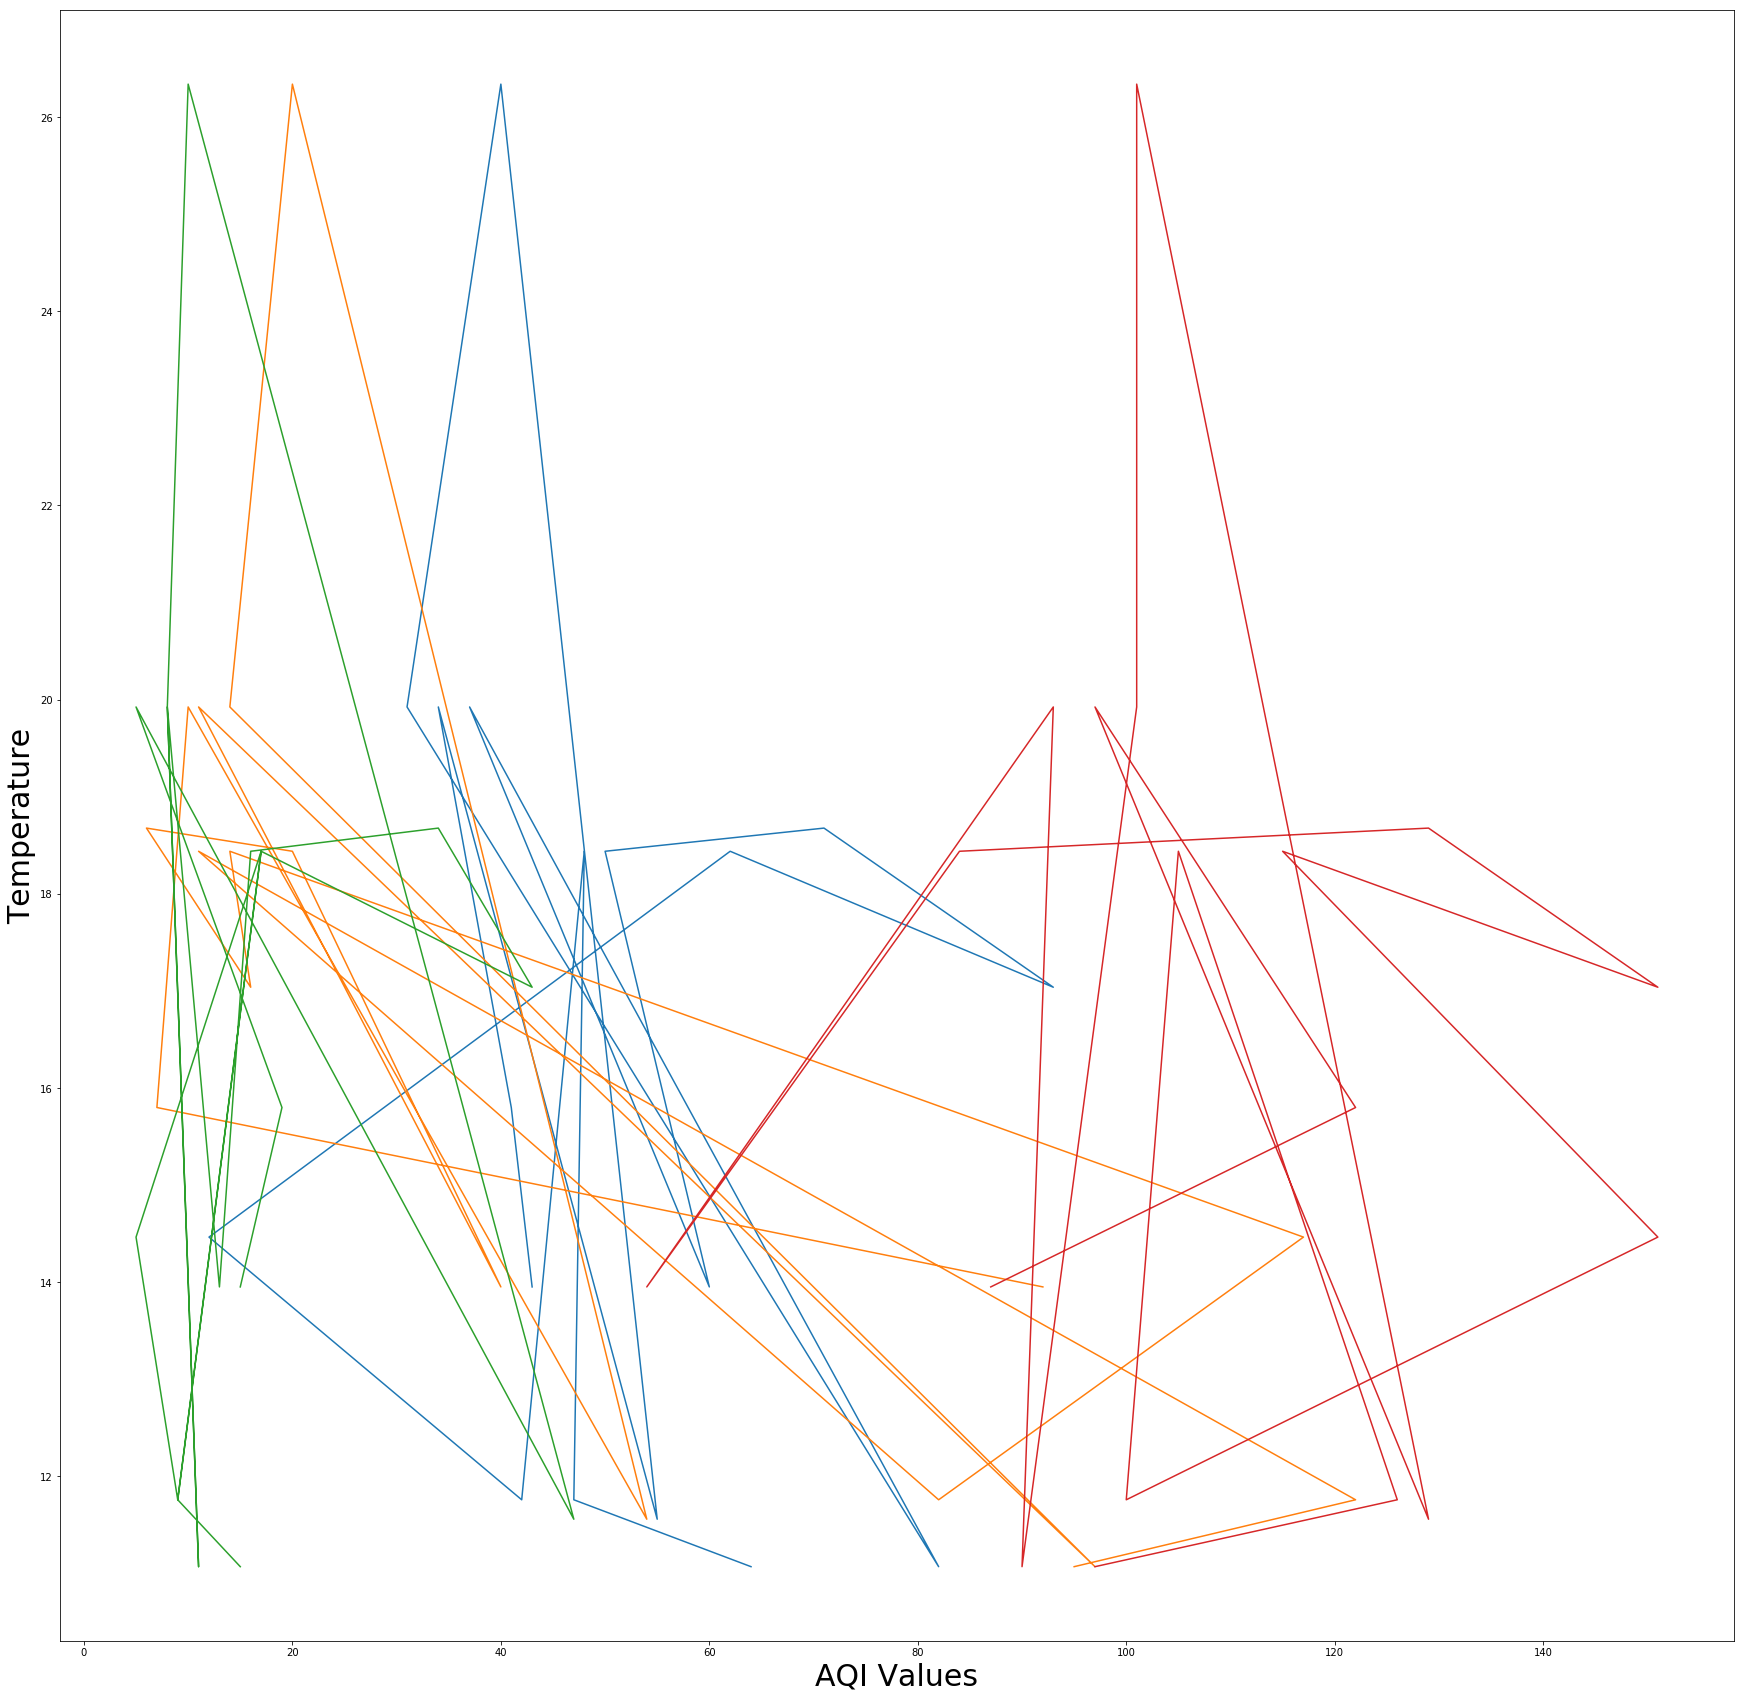

In [98]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[30,30])

y_values = [x for x in list_target]
x_values = [x for x in list_features]
plt.xlabel("AQI Values",fontsize=30)
plt.ylabel("Temperature",fontsize=30)
plt.plot(x_values,y_values)
plt.show()

In [239]:
import pandas as pd
import numpy as np
causes_of_death=pd.read_csv("NCHS_-_Leading_Causes_of_Death__United_States.csv")

In [240]:
not_wanted_diseases_list=[
                          'All Causes',
                          'Assault (homicide) (*U01-*U02,X85-Y09,Y87.1)',
                          'Assault (homicide) by discharge of firearms (*U01.4,X93-X95)',
                          'Assault (homicide) by other and unspecified means and their sequelae (*U01.0-*U01.3,*U01.5-*U01.9,*U02,X85-X92,X96-Y09,Y87.1)'
                          'Legal intervention (Y35,Y89.0)',
                          'Events of undetermined intent (Y10-Y34,Y87.2,Y89.9)',
                          'Discharge of firearms, undetermined intent (Y22-Y24)',
                          'Other and unspecified events of undetermined intent and their sequelae (Y10-Y21,Y25-Y34,Y87.2,Y89.9)',
                          'Operations of war and their sequelae (Y36,Y89.1)',
                          'Complications of medical and surgical care (Y40-Y84,Y88)',
                          'Other land transport accidents (V01,V05-V06,V09.1,V09.3-V09.9, V10-V11,V15-V18,V19.3,V19.8-V19.9,V80.0-V80.2,V80.6-V80.9,V81.2-V81.9,V82.2-V82.9,V87.9,V88.9,V89.1,V89.3,V89.9)',
                          'Water, air and space, and other and unspecified transport accidents and theirsequelae (V90-V99,Y85)',
                          'Nontransport accidents (W00-X59,Y86)',
                          'Falls (W00-W19)',
                          'Accidental discharge of firearms (W32-W34)',
                          'Accidental drowning and submersion (W65-W74)',
                          'Accidental exposure to smoke, fire and flames (X00-X09)',
                          'Accidental poisoning and exposure to noxious substances (X40-X49)',
                          'Other and unspecified nontransport accidents and their sequelae (W20-W31,W35-W64,W75-W99,X10-X39,X50-X59,Y86)',
                          'Intentional self-harm (suicide) (*U03,X60-X84,Y87.0)',
                          'Intentional self-harm (suicide) by discharge of firearms (X72-X74)',
                          'Intentional self-harm (suicide) by other and unspecified means and their sequelae (*U03,X60-X71,X75-X84,Y87.0)',
                          'Accidents (unintentional injuries) (V01-X59,Y85-Y86)',
                          'Transport accidents (V01-V99,Y85)',
                          'Motor vehicle accidents (V02-V04,V09.0,V09.2,V12-V14,V19.0-V19.2,V19.4-V19.6,V20-V79,V80.3-V80.5,V81.0-V81.1,V82.0-V82.1,V83-V86,V87.0-V87.8,V88.0-V88.8,V89.0,V89.2)',
                          'All other diseases (Residual) (D65-E07,E15-E34,E65-F99,G04-G14,G23-G25,G31-H93,K00-K22,K29-K31,K50-K66,K71-K72,K75-K76,K83-M99, N13.0-N13.5,N13.7-N13.9,N14,N15.0,N15.8-N15.9,N20-N23,N28-N39,N41-N64,N80-N98)'
                                                 
                         ]
causes_of_death = causes_of_death[~causes_of_death['113 Cause Name'].isin(not_wanted_diseases_list)]
causes_of_death.shape
causes_of_death.to_csv("Leading_Causes_of_death.csv")


In [241]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
# converting the date from string to DateTime format using UDF
func =  udf (lambda x: datetime.strptime(x, '%Y'), DateType())



In [242]:
import pyspark
from pyspark.sql import SQLContext
from pyspark import SparkContext
sc =SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
df = sqlContext.read.csv("Leading_Causes_of_death.csv", header=True)
df = df.withColumn('Year', func(col('Year')))
df.printSchema()
df.registerTempTable("Death_data_Set")


root
 |-- _c0: string (nullable = true)
 |-- Year: date (nullable = true)
 |-- 113 Cause Name: string (nullable = true)
 |-- Cause Name: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Deaths: string (nullable = true)
 |-- Age-adjusted Death Rate: string (nullable = true)



In [243]:
death=sqlContext.sql("SELECT YEAR(Year) AS Years,`113 Cause Name`,State, Deaths FROM Death_data_Set ")

In [244]:
death.show()
death.registerTempTable("Death_dataset")

+-----+--------------------+--------------------+------+
|Years|      113 Cause Name|               State|Deaths|
+-----+--------------------+--------------------+------+
| 1999|Alzheimer's disea...|             Alabama| 772.0|
| 1999|Alzheimer's disea...|              Alaska|  24.0|
| 1999|Alzheimer's disea...|             Arizona| 963.0|
| 1999|Alzheimer's disea...|            Arkansas| 434.0|
| 1999|Alzheimer's disea...|          California|4532.0|
| 1999|Alzheimer's disea...|            Colorado| 756.0|
| 1999|Alzheimer's disea...|         Connecticut| 449.0|
| 1999|Alzheimer's disea...|            Delaware| 107.0|
| 1999|Alzheimer's disea...|District of Columbia|  53.0|
| 1999|Alzheimer's disea...|             Florida|3059.0|
| 1999|Alzheimer's disea...|             Georgia|1080.0|
| 1999|Alzheimer's disea...|              Hawaii| 109.0|
| 1999|Alzheimer's disea...|               Idaho| 243.0|
| 1999|Alzheimer's disea...|            Illinois|1908.0|
| 1999|Alzheimer's disea...|   

In [245]:
from pyspark.sql.types import IntegerType
death=death.withColumn("Years", death["Years"].cast(IntegerType()))

In [246]:
death.describe()

DataFrame[summary: string, Years: string, 113 Cause Name: string, State: string, Deaths: string]

<h1>The average number of deaths each year for each disease for each State<h1>

In [251]:
D=sqlContext.sql("SELECT  Years as Years,avg(CAST(Death_dataset.`Deaths` AS DOUBLE)) AS Deaths,State,`113 Cause Name` FROM Death_dataset GROUP BY  State,`113 Cause Name`, Years ORDER BY Years,State,Deaths")


In [252]:
D.registerTempTable("Disease")
D.describe()

DataFrame[summary: string, Years: string, Deaths: string, State: string, 113 Cause Name: string]

In [253]:
from pyspark.sql.types import DoubleType

D = D.withColumn("Deaths", D["Deaths"].cast(DoubleType()))

In [256]:
sqlContext.sql("SELECT * FROM Disease WHERE Deaths IS NOT NULL  GROUP BY `113 Cause Name`, Years,Deaths,State ORDER BY  Years, Deaths DESC").show(100)

+-----+--------+--------------+--------------------+
|Years|  Deaths|         State|      113 Cause Name|
+-----+--------+--------------+--------------------+
| 1999|725192.0| United States|Diseases of heart...|
| 1999|549838.0| United States|Malignant neoplas...|
| 1999|167366.0| United States|Cerebrovascular d...|
| 1999|124181.0| United States|Chronic lower res...|
| 1999| 71930.0|    California|Diseases of heart...|
| 1999| 68399.0| United States|Diabetes mellitus...|
| 1999| 63730.0| United States|Influenza and pne...|
| 1999| 58987.0|      New York|Diseases of heart...|
| 1999| 53067.0|    California|Malignant neoplas...|
| 1999| 51434.0|       Florida|Diseases of heart...|
| 1999| 44536.0| United States|Alzheimer's disea...|
| 1999| 43418.0|         Texas|Diseases of heart...|
| 1999| 41707.0|  Pennsylvania|Diseases of heart...|
| 1999| 38478.0|       Florida|Malignant neoplas...|
| 1999| 37609.0|      New York|Malignant neoplas...|
| 1999| 35525.0| United States|Nephritis, neph

In [257]:
table=sqlContext.sql("SELECT * FROM Disease WHERE Deaths IS NOT NULL ORDER BY Deaths DESC")
table.registerTempTable("Death_Data_Set")

In [259]:
sqlContext.sql("SELECT MAX(Deaths) AS Max_Deaths,`113 Cause Name` as Causes, Years, State From Death_Data_Set WHERE State != 'United States' GROUP BY  Years, `113 Cause Name`, State ORDER BY Years,MAX(Deaths) DESC").show(10)

+----------+--------------------+-----+------------+
|Max_Deaths|              Causes|Years|       State|
+----------+--------------------+-----+------------+
|   71930.0|Diseases of heart...| 1999|  California|
|   58987.0|Diseases of heart...| 1999|    New York|
|   53067.0|Malignant neoplas...| 1999|  California|
|   51434.0|Diseases of heart...| 1999|     Florida|
|   43418.0|Diseases of heart...| 1999|       Texas|
|   41707.0|Diseases of heart...| 1999|Pennsylvania|
|   38478.0|Malignant neoplas...| 1999|     Florida|
|   37609.0|Malignant neoplas...| 1999|    New York|
|   33387.0|Diseases of heart...| 1999|    Illinois|
|   33192.0|Diseases of heart...| 1999|        Ohio|
+----------+--------------------+-----+------------+
only showing top 10 rows



In [271]:
result=sqlContext.sql("SELECT MAX(Deaths) AS Max_Deaths,`113 Cause Name` as Causes, Years as Yearly, State From Death_Data_Set WHERE State != 'United States' GROUP BY  Years, `113 Cause Name`, State ORDER BY Years,MAX(Deaths) DESC")


In [273]:
from pyspark.sql.types import IntegerType
result=result.withColumn("Yearly", result["Yearly"].cast(IntegerType()))
result.registerTempTable("max_city_wise_death")

In [279]:
result.printSchema()

root
 |-- Max_Deaths: double (nullable = true)
 |-- Causes: string (nullable = true)
 |-- Yearly: integer (nullable = true)
 |-- State: string (nullable = true)



In [278]:
t1.printSchema()

root
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Max_NO2_AQI: double (nullable = true)
 |-- Max_SO2_AQI: double (nullable = true)
 |-- MAX_O3_AQI: double (nullable = true)
 |-- Max_CO_AQI: double (nullable = true)
 |-- Yearly: integer (nullable = true)



<h3> Joining the Death Data set with the pollution data set to check how the pollution effects death in different cities. </h3>

In [292]:
sqlContext.sql("SELECT Entire_Pollution.Yearly,max_city_wise_death.Max_Deaths, max_city_wise_death.Causes,max_city_wise_death.State,Entire_Pollution.City,Entire_Pollution.Max_NO2_AQI,Entire_Pollution.Max_SO2_AQI, Entire_Pollution.Max_CO_AQI,Entire_Pollution.MAX_O3_AQI FROM Entire_Pollution JOIN max_city_wise_death ON max_city_wise_death.State==Entire_Pollution.State AND Entire_Pollution.Yearly=max_city_wise_death.Yearly GROUP BY Entire_Pollution.Yearly,max_city_wise_death.State,Entire_Pollution.City,max_city_wise_death.Causes,max_city_wise_death.Max_Deaths, Entire_Pollution.Max_NO2_AQI,Entire_Pollution.Max_SO2_AQI, Entire_Pollution.Max_CO_AQI,Entire_Pollution.MAX_O3_AQI ORDER BY Entire_Pollution.Yearly ,max_city_wise_death.Max_Deaths DESC").show(10)

+------+----------+--------------------+----------+--------------------+-----------+-----------+----------+----------+
|Yearly|Max_Deaths|              Causes|     State|                City|Max_NO2_AQI|Max_SO2_AQI|Max_CO_AQI|MAX_O3_AQI|
+------+----------+--------------------+----------+--------------------+-----------+-----------+----------+----------+
|  2000|   68426.0|Diseases of heart...|California|       Bethel Island|       41.0|       26.0|      17.0|     124.0|
|  2000|   68426.0|Diseases of heart...|California|             Vallejo|       62.0|       24.0|      57.0|      47.0|
|  2000|   68426.0|Diseases of heart...|California|          Long Beach|      108.0|       65.0|      63.0|     114.0|
|  2000|   68426.0|Diseases of heart...|California|         Victorville|       94.0|       36.0|      18.0|     179.0|
|  2000|   68426.0|Diseases of heart...|California|       Not in a city|       84.0|       21.0|      35.0|     154.0|
|  2000|   68426.0|Diseases of heart...|Californ

In [294]:
Pollution_wise_Death=sqlContext.sql("SELECT Entire_Pollution.Yearly,max_city_wise_death.Max_Deaths, max_city_wise_death.Causes,max_city_wise_death.State,Entire_Pollution.City,Entire_Pollution.Max_NO2_AQI,Entire_Pollution.Max_SO2_AQI, Entire_Pollution.Max_CO_AQI,Entire_Pollution.MAX_O3_AQI FROM Entire_Pollution JOIN max_city_wise_death ON max_city_wise_death.State==Entire_Pollution.State AND Entire_Pollution.Yearly=max_city_wise_death.Yearly GROUP BY Entire_Pollution.Yearly,max_city_wise_death.State,Entire_Pollution.City,max_city_wise_death.Causes,max_city_wise_death.Max_Deaths, Entire_Pollution.Max_NO2_AQI,Entire_Pollution.Max_SO2_AQI, Entire_Pollution.Max_CO_AQI,Entire_Pollution.MAX_O3_AQI ORDER BY Entire_Pollution.Yearly ,max_city_wise_death.Max_Deaths DESC")
Pollution_wise_Death.toPandas().to_csv("Pollution_wise_Death.csv")